# ECS7020P mini-project basic


# 1 Author

**Student Name**: Eleanor Prashamshini  
**Student ID**: 220772291 



# 2 Problem formulation

Given a corpus of audio files and information about their recording locations, can we build a machine learning model that predicts whether an audio clip has been recorded indoors or outdoors?

# 3 Machine Learning pipeline

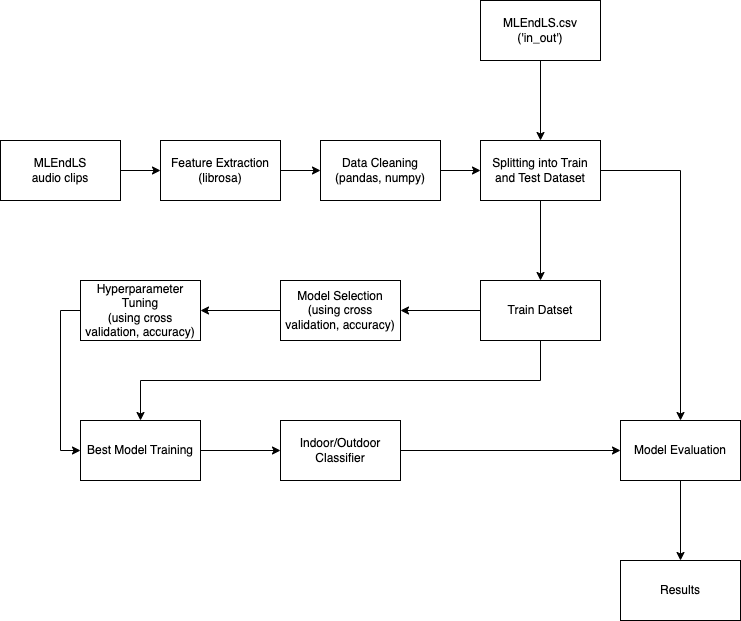

Input - Audio files and Labels

Feature Extraction - converting audio files into frequency, power and other interpretable features

Data Cleaning - removing broken files, and other unsuitable values

Feature selection - removing columns with high correlation

Model Validation - Selecting a family of models that suits our use case

Model Tuning - Finding hyper parameters best suited

Training - Training our classifier

Testing - Evaluating the classifier performance

In [1]:
# Imports
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa, librosa.display

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Accessing Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# 4 Transformation stage

A sound segment is rich in data. However, providing all the signal data points as input to the machine learning model would only confuse it because we do not have enough data to generalise the model training, this would result in the model overfitting the training dataset and poor performance on the test dataset. Instead, we can extract features of the audio signal that communicate essential characteristics of the audio.

In [3]:
# Viewing the list of files/directories in `path`
path = '/content/drive/MyDrive/Data/MLEndLS'
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEndLS/MLEndLS/'
dirs = os.listdir(path)
dirs

['sample',
 'MLEndLS_1.zip',
 'MLEndLS_2.zip',
 'MLEndLS_3.zip',
 'MLEndLS_4.zip',
 'MLEndLS_5.zip',
 'MLEndLS']

In [ ]:
# Unzipping all the zip files and consolidating all the audio files in a single folder
for f in dirs:
  # Checking if it is a *.zip file before extracting
  if re.search('.zip$', f) != None:
    zip_path = path+'/'+f
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

In [4]:
# Checking the total number of audio files
audio_path = '/content/drive/MyDrive/Data/MLEndLS/MLEndLS/*.wav'
files = glob.glob(audio_path)
files.sort() # order ascending by default
total_files = len(files)
total_files

2500

In [7]:
def load_audio(file_no, fs=22050, display_audio=False):
  """
  Loading an audio file based on file number and 
  providing an audio component to play the clip

  Input:
  file_no - file number to be loaded
  fs - frequency of sampling per second; default 22050
  display_audio - set True to display audio component; default False

  Output:
  x - sample points
  fs - frequency of sampling per second
  """
  
  global files
  
  n = file_no - 1 # n is index

  if n > len(files) or n < 0:
    print("Invalid file number")
    return 0, 0

  # Loading audio file
  x, _ = librosa.load(files[n], sr=fs)
  print(files[n], ': audio signal has', len(x), 'samples')
  
  if display_audio == True:
    # Display component for listening to audio
    display(ipd.Audio(files[n]))
  
  return x, fs

In [ ]:
# Testing
file_no_test = 1
x_test, fs = load_audio(file_no_test, display_audio=True)
print(fs)

In [8]:
def load_audio_by_name(file_name, fs=22050, display_audio=False):
  """
  Loading an audio file based on file name and 
  providing an audio component to play the clip

  Input:
  file_name - name of the file to be loaded
  fs - frequency of sampling per second; default 22050
  display_audio - set True to display audio component; default False

  Output:
  x - sample points
  fs - frequency of sampling per second
  """

  global files, directory_to_extract_to
  
  complete_path = directory_to_extract_to + file_name
  file_no = files.index(complete_path) + 1 
  
  return load_audio(file_no, fs, display_audio)

In [ ]:
# Testing
file_name_test = '0001.wav' 
x_test, fs = load_audio_by_name(file_name_test, display_audio=True)
print(fs)

/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0001.wav : audio signal has 211460 samples


22050


Every audio file contains a segment at the beginning where the recorder says "This is London." We want to try and separate this speech marker from the rest of the audio clip. Using the `librosa.pyin` function we can identify the voice segements and their pitch, however separating only the introduction (intro) from the rest of the voices is difficult. 

Taking a random sample of 25 audio clips from the corpus and manually scanning them, here are some observations:


In [21]:
np.random.seed(1) # setting seed for reproducing results

# Sampling 25 random files from the entire collection
samples_25 = np.random.randint(1, 2500, size=(25))
for i in samples_25:
  load_audio(i, display_audio=False) # set to true to view here

samples_25

array([1062,  236, 1097,  906,  961,  145,  130, 1203, 1301, 1279,  358,
        253,  669, 2447,  563,  754, 1528, 1889, 1111, 2190, 2026, 1032,
        320, 1338, 1921])

In [ ]:
# Observations of intro end (roughly)
obs_samples_25 = [3, 2, 1, 1, 1, 
                  2, 1, 0, 1, 2, 
                  2, 1, 0, 2, 1, 
                  3, 1, 2, 1, 2, 
                  2, 2, 1, 3, 1]
print('Observed end of intro:', obs_samples_25)
print('min:', np.min(obs_samples_25), 'sec \nmax:', np.max(obs_samples_25), 'sec')
print('mean:', np.mean(obs_samples_25), 'sec \nstd:', np.std(obs_samples_25))

Observed end of intro: [3, 2, 1, 1, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 1, 3, 1, 2, 1, 2, 2, 2, 1, 3, 1]
min: 0 sec 
max: 3 sec
mean: 1.52 sec 
std: 0.8059776671843953


Using the above max and mean we define conditions for identifying the the speech marker if it is distinguishable by pitch from the rest of the audio.

Using the **sampled audio clip as input**, the voice features extracted are:
1. **Voice Fraction** - fraction of speech in the clip
2. **Pitch** (mean and standard deviation) - the human perception of voice in the intro
3. **Power** - the loudness of voice in the intro, calculated using the Root-Mean-Square energy

In [ ]:
def getVoiceFeatures(x, fs=22050, winLen=0.05):
  """
  Calculate the overall voice fraction,
  extract the pitch and power of the intro and the end of speech marker

  Input:
  x - sample points
  fs - frequency of sampling per second; default 22050
  winLen - window length; default 0.05

  Output:
  voice_features - list of extracted features for the voice segment
  feature_names - list of extracted features
  speech_marker_end - ending index of intro
  """
  
  voice_features = [] # for the values
  feature_names = [] # for the names

  duration = len(x) / fs
  print('x:', len(x), 'fs:', fs, 'time', duration, 's')
  
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//4
  f0, voiced_flags, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, 
                                                frame_length=frame_length,
                                                hop_length=hop_length)
  
  # Voice Fraction
  voiced_fr = np.mean(voiced_flags)
  voice_features.append(voiced_fr)
  feature_names.append('voiced_fr')
  
  this_is_london = [] # for the pitch of voice parts
  speech_marker_end = 0 # for index of intro end
  for i in range(len(f0)):
    # i lesser than 3 sec (max observed)
    if (voiced_flags[i] == True) and (i < (3 * len(f0)/duration)):
      this_is_london.append(f0[i])
    
    # i lesser than 1.52 sec (mean observed)
    elif i > (1.52 * len(f0)/duration):
      # Calculate the end marker in the actual x
      speech_marker_end = round((i + 1) * (len(x) / len(f0)))
      break

  # Power of intro voice segment
  intro_stft = librosa.stft(x[:speech_marker_end]) # short-term Fourier transform
  S, phase = librosa.magphase(intro_stft)
  intro_rms = librosa.feature.rms(S=S)
  intro_power = np.sum(intro_rms**2)/len(intro_rms)
  voice_features.append(intro_power)
  feature_names.append('intro_power')

  # Pitch mean and std
  intro_pitch_mean = np.mean(this_is_london)
  voice_features.append(intro_pitch_mean)
  feature_names.append('intro_pitch_mean')
  intro_pitch_std = np.std(this_is_london)
  voice_features.append(intro_pitch_std)
  feature_names.append('intro_pitch_std')

  return voice_features, feature_names, speech_marker_end

In [ ]:
# Testing
vf_test, vfn_test, end_test = getVoiceFeatures(x_test, fs)
print('No. of intro features:', len(vf_test))
print('List of features:', vfn_test)
print('Feature values:', vf_test)

x: 155232 fs: 22050 time 7.04 s
No. of intro features: 4
List of features: ['voiced_fr', 'intro_power', 'intro_pitch_mean', 'intro_pitch_std']
Feature values: [0.12828947368421054, 0.498415928974282, 198.1866247995614, 35.03503403186076]


The clips record the all sounds in a location, such as people talking, music, rushing water and many other sounds. We need to extract features that can  characterise the all varieties of sounds.

The sound features extracted by providing the **sampled audio clip as input**:
1. **Power** - the overall loudness of the clip, calculated using the Root-Mean-Square energy
2. **Tempo** - speed, measured in beats per minute and averaged across the entire clip
3. **Zero crossing** (count, rate mean and rate std) - changing of signal from positive to negative and vice versa
4. **Chroma** (mean and std for every scale) - characterises the pitch on the 12 scales (C, C♯, D, D♯, E, F, F♯, G, G♯, A, A♯, B) and can be visualised in a chromagram
5. **Mel Frequency Cepstral Coefficients** (mean and std for each coeff) - uses the mel scale, which characterise distance in pitch to distance from listener. Based on the number of coefficients, the audio is passed through that many filters and we get heatmap of the audio clip modelling frequency against time.
6. **First and second derivative of MFCC** (mean and std for each coeff) - this is calculated to observe the change of the above coefficients over time.

In [ ]:
def getSoundFeatures(x, fs=22050, winLen=0.05):
  """
  Extract power, Tempo, ZCR, Chromagram and
  MFCC (including delta order 1 and 2)

  Input:
  x - sample points
  fs - frequency of sampling per second; default 22050
  winLen - window length; default 0.05

  Output:
  sound_features - list of extracted features for the clip passed
  feature_names - list of extracted features
  """

  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//4

  duration = len(x) / fs
  sound_features = []
  feature_names = []

  # Power
  X_stft = librosa.stft(x) # short-term Fourier transform
  S, phase = librosa.magphase(X_stft)
  X_rms = librosa.feature.rms(S=S)
  X_power = np.sum(x**2)/len(x)
  sound_features.append(X_power) # sound_features[0]
  feature_names.append('power')

  # Tempo
  X_oenv = librosa.onset.onset_strength(y=x, sr=fs, hop_length=hop_length)
  X_tempo = librosa.beat.tempo(onset_envelope=X_oenv, sr=fs, 
                               hop_length=hop_length)[0]
  sound_features.append(X_tempo) # sound_features[1]
  feature_names.append('tempo')

  # Zero Crossing count and rate
  zc_count = sum(librosa.zero_crossings(x))
  zc_mean = zc_count/duration
  sound_features.append(zc_mean) # sound_features[2]
  feature_names.append('zc_mean')
  X_zcr = librosa.feature.zero_crossing_rate(x)
  zcr_mean = np.mean(X_zcr.T, axis = 0)
  sound_features.extend(zcr_mean) # sound_features[3]
  feature_names.append('zcr_mean')
  zcr_std = np.std(X_zcr.T, axis = 0)
  sound_features.extend(zcr_std) # sound_features[4]
  feature_names.append('zcr_std')

  # Chromagram (24 features)
  X_chromagram = librosa.feature.chroma_stft(x, sr=fs, hop_length=hop_length)
  chroma_mean = np.mean(X_chromagram.T, axis=0)
  sound_features.extend(chroma_mean) # sound_features[5:17]
  feature_names.extend(['chroma_mean_'+str(i) for i in range(1, len(chroma_mean)+1)])
  chroma_std = np.std(X_chromagram.T, axis=0)
  sound_features.extend(chroma_std) # sound_features[17:29]
  feature_names.extend(['chroma_std_'+str(i) for i in range(1, len(chroma_std)+1)])

  # MFCC (26 features)
  X_mfcc = librosa.feature.mfcc(x, sr=fs, n_mfcc=13) # n_mfcc=20 by default
  mfcc_mean = np.mean(X_mfcc.T, axis=0)
  sound_features.extend(mfcc_mean) # sound_features[29:42]
  feature_names.extend(['mfcc_mean_'+str(i) for i in range(1, len(mfcc_mean)+1)])
  mfcc_std = np.std(X_mfcc.T, axis=0)
  sound_features.extend(mfcc_std) # sound_features[42:55]
  feature_names.extend(['mfcc_std_'+str(i) for i in range(1, len(mfcc_std)+1)])
  
  # Delta MFCC order 1 (26 features)
  X_d_mfcc = librosa.feature.delta(X_mfcc)
  d_mfcc_mean = np.mean(X_d_mfcc.T, axis=0)
  sound_features.extend(d_mfcc_mean) # sound_features[55:68]
  feature_names.extend(['d_mfcc_mean_'+str(i) for i in range(1, len(d_mfcc_mean)+1)])
  d_mfcc_std = np.std(X_d_mfcc.T, axis=0)
  sound_features.extend(d_mfcc_std) # sound_features[68:81]
  feature_names.extend(['d_mfcc_std_'+str(i) for i in range(1, len(d_mfcc_std)+1)])

  # Delta MFCC order 2  (26 features)
  X_d2_mfcc = librosa.feature.delta(X_mfcc, order=2)
  d2_mfcc_mean = np.mean(X_d2_mfcc.T, axis=0)
  sound_features.extend(d2_mfcc_mean) # sound_features[81:94]
  feature_names.extend(['d2_mfcc_mean_'+str(i) for i in range(1, len(d2_mfcc_mean)+1)])
  d2_mfcc_std = np.std(X_d2_mfcc.T, axis=0)
  sound_features.extend(d2_mfcc_std) # sound_features[94:]
  feature_names.extend(['d2_mfcc_std_'+str(i) for i in range(1, len(d2_mfcc_std)+1)])

  # total sound features is 107

  return sound_features, feature_names

In [ ]:
# Testing
sf_test, sfn_test = getSoundFeatures(x_test[end_test:], fs)
print('No. of sound features:', len(sf_test))
print('List of features:', sfn_test)
print('Feature values:', sf_test)

No. of sound features: 107
List of features: ['power', 'tempo', 'zc_mean', 'zcr_mean', 'zcr_std', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3', 'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7', 'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11', 'chroma_mean_12', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3', 'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7', 'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11', 'chroma_std_12', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13', 'd_mfcc_mean_1', 'd_mfcc_mean_2', 'd_mfcc_mean_3', 'd_mfcc_mean_4', 'd_mfcc_mean_5', 'd_mfcc_mean_6', 'd_mfcc_mean_

**The total number of features extracted from an audio clip is 111.**

# 5 Modelling


Our goal is to predicts if an audio clip is one of two classes, indoor or outdoor. Given the `MLEndLS.csv`, using the `in_out` column and previously extracted features, we can create a labelled training dataset and use a **supervised machine learning classifier** to achieve our goal. 

List of ML classifiers that will explored -
1. Logistic Regression - statistic method that predicts outcome of a dependent variable based on previous observations.
2. Naive Bayes - applies Bayes theorem and assumes that features are independent. Some of our features are derived from others, like 1st and 2nd derivative of MFCC.
3. Linear Support Vector Machines - identifies the best decision hyperplane to divide the two classes. Useful when there is a large number of features and smaller dataset.
4. K-Nearest Neighbours - classifies based on the neighbouring points. There chances of overfitting the training data.
5. Decision Tree - works similar to flowchart and identifies  for branching conditions using features. Doesn't work well with continuous data usually.


In [ ]:
family_models = [ LogisticRegression(), 
                 GaussianNB(), 
                 LinearSVC(), 
                 KNeighborsClassifier(), 
                 DecisionTreeClassifier()]

# 6 Methodology

## Model training and testing

First we divide the dataset into training and test datasets - 80:20 (Pareto principle). 

Using the training dataset and k-fold cross validation we will -
1. validate families of models with default parameters and select the high performing models
2. perform hyperparameter tuning for the selected models and pick one model

Once we have the model and its hyperparameters are decided we will  fit it with the training dataset. This is our final model and will be evaluated with the test dataset.

## Evaluation Metrics

We will be using accuracy (A) to compare the performance of different models, as it gives a measure of the correctly classified samples overall. 

A = (TP + TN) / Total Count 

Since we will be using k-fold cross validation, accuracy is determined as the mean accuracy across all folds. Additionally, it is important to note the standard devation across the folds, as it tells us about the stability of our performance metric.


To evaluate the final models performance on the test set we will be using accuracy, F1-score and confusion matrix. 

F1-score (F1) - it combines precision and recall in a single metric and helps balance both. We need precision and recall to understand internal class performances. 

F1 = (2 x Precision x Recall) / (Precision + Recall)

Precision = TP / (TP + FP); Recall = TP / (TP + FN)

Confusion matrix - to get better visual understanding of class performances.

In [ ]:
def cvFamilyOfModels(x, y, family_models, k=5, eval_metric='accuracy', scaler=False):
  """
  Using cross-validation method to evaluate families of models

  Input:
  x - dataset
  y - labels
  family_models - families of models
  k - number of folds in cross validation; default 5
  eval_metric - the metric used for evaluation; default 'accuracy'
  scaler - set to true if z-score normalisation needs to be performed; default False

  Output:
  model_scores - dict of models and their accuracy 
  """
  model_scores = {}
  
  if scaler == True:
    scaler = StandardScaler()
    scaler.fit(x)
    x1 = scaler.transform(x)
  else:
    x1 = x

  for model in family_models:
    model.fit(x1, y)
    kfold_cv = KFold(n_splits=k, random_state=1, shuffle=True)
    scores = cross_val_score(model, x1, y, scoring=eval_metric, cv=kfold_cv, n_jobs=-1)
    model_scores[type(model).__name__] = [np.mean(scores), np.std(scores)]

  return model_scores

In [ ]:
def tuningModel(x, y, model, model_params, scaler=True):
  """
  Using Grid Search cross validation to find the best parameters for a model

  Input:
  x - dataset
  y - labels
  model - model to e tuned
  model_params - the parameters values for tuning
  scaler - set to true if z-score normalisation needs to be performed; default True

  Output:
  DataFrame of results
  """
  if scaler == True:
    scaler = StandardScaler()
    scaler.fit(x)
    x1 = scaler.transform(x)
  else:
    x1 = x
  
  clf = GridSearchCV(model, model_params)
  clf.fit(x1, y)
  return pd.DataFrame.from_dict(clf.cv_results_)[['mean_fit_time', 'params', 
                                                  'mean_test_score', 'std_test_score',
                                                  'rank_test_score']]

# 7 Dataset

The MLEnd London Sounds dataset will be used in creating our model. The dataset, at this time of use (Dec 2022) consists of 2500 recordings from 36 locations around London. The participants contributing to this database are students in ECS7020: Principles of Machine Learning module, 2022 cohort. The database has been reviewed and consolidated by the module convenor, Jesus Requena-Carrion, and his team. They have additionally created a CSV file that captures metadata about the recordings - indoor/outdoor, area, spot and participant. We will only be using the indoor/outdoor information from this file.

## 7.1 Feature Extraction

In [22]:
# Loading the MLEndLS.csv file with area, spot, in_out and participant info 
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 
MLENDLS_df.shape

(2500, 4)

In [ ]:
audio_df = pd.DataFrame(columns=('voiced_fr', 'intro_power', 'intro_pitch_mean', 
                                 'intro_pitch_std', 'power', 'tempo', 'zc_mean', 
                                 'zcr_mean', 'zcr_std', 'chroma_mean_1', 
                                 'chroma_mean_2', 'chroma_mean_3', 'chroma_mean_4', 
                                 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7', 
                                 'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 
                                 'chroma_mean_11', 'chroma_mean_12', 'chroma_std_1', 
                                 'chroma_std_2', 'chroma_std_3', 'chroma_std_4', 
                                 'chroma_std_5', 'chroma_std_6', 'chroma_std_7', 
                                 'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 
                                 'chroma_std_11', 'chroma_std_12', 'mfcc_mean_1', 
                                 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 
                                 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 
                                 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 
                                 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 
                                 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 
                                 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 
                                 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 
                                 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 
                                 'mfcc_std_13', 'd_mfcc_mean_1', 'd_mfcc_mean_2', 
                                 'd_mfcc_mean_3', 'd_mfcc_mean_4', 'd_mfcc_mean_5', 
                                 'd_mfcc_mean_6', 'd_mfcc_mean_7', 'd_mfcc_mean_8', 
                                 'd_mfcc_mean_9', 'd_mfcc_mean_10', 'd_mfcc_mean_11', 
                                 'd_mfcc_mean_12', 'd_mfcc_mean_13', 'd_mfcc_std_1', 
                                 'd_mfcc_std_2', 'd_mfcc_std_3', 'd_mfcc_std_4', 
                                 'd_mfcc_std_5', 'd_mfcc_std_6', 'd_mfcc_std_7', 
                                 'd_mfcc_std_8', 'd_mfcc_std_9', 'd_mfcc_std_10', 
                                 'd_mfcc_std_11', 'd_mfcc_std_12', 'd_mfcc_std_13', 
                                 'd2_mfcc_mean_1', 'd2_mfcc_mean_2', 'd2_mfcc_mean_3', 
                                 'd2_mfcc_mean_4', 'd2_mfcc_mean_5', 'd2_mfcc_mean_6', 
                                 'd2_mfcc_mean_7', 'd2_mfcc_mean_8', 'd2_mfcc_mean_9', 
                                 'd2_mfcc_mean_10', 'd2_mfcc_mean_11', 'd2_mfcc_mean_12', 
                                 'd2_mfcc_mean_13', 'd2_mfcc_std_1', 'd2_mfcc_std_2', 
                                 'd2_mfcc_std_3', 'd2_mfcc_std_4', 'd2_mfcc_std_5', 
                                 'd2_mfcc_std_6', 'd2_mfcc_std_7', 'd2_mfcc_std_8', 
                                 'd2_mfcc_std_9', 'd2_mfcc_std_10', 'd2_mfcc_std_11', 
                                 'd2_mfcc_std_12', 'd2_mfcc_std_13'))

In [ ]:
ml_index = MLENDLS_df.index
for i in range(0, len(ml_index)): 
  f = ml_index[i] # file name
  
  # Load Audio
  x, fs = load_audio_by_name(f)
  
  # Extract Features
  vf, vfn, voice_end = getVoiceFeatures(x, fs)
  sf, sfn = getSoundFeatures(x[voice_end:], fs)
  
  # Initialise row in dataframe as NaN values
  audio_df.loc[f] = [np.NaN] * 111
  
  # Adding voice features
  for j in range(len(vfn)):
    audio_df[vfn[j]].loc[ml_index[i]] = vf[j]
  
  # Adding sound features
  for j in range(len(sfn)):
    audio_df[sfn[j]].loc[ml_index[i]] = sf[j]

print(audio_df.shape)
audio_df.head()

/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0001.wav : audio signal has 211460 samples
x: 211460 fs: 22050 time 9.59002267573696 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0002.wav : audio signal has 155232 samples
x: 155232 fs: 22050 time 7.04 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0003.wav : audio signal has 195143 samples
x: 195143 fs: 22050 time 8.85002267573696 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0004.wav : audio signal has 170226 samples
x: 170226 fs: 22050 time 7.72 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0005.wav : audio signal has 251811 samples
x: 251811 fs: 22050 time 11.42 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0006.wav : audio signal has 183236 samples
x: 183236 fs: 22050 time 8.310022675736962 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0007.wav : audio signal has 168903 samples
x: 168903 fs: 22050 time 7.66 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0008.wav : audio signal has 158760 samples
x: 158760 fs: 22050 time 7.2 s
/content/dr

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0034.wav : audio signal has 199553 samples
x: 199553 fs: 22050 time 9.050022675736962 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0035.wav : audio signal has 170226 samples
x: 170226 fs: 22050 time 7.72 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0036.wav : audio signal has 160304 samples
x: 160304 fs: 22050 time 7.2700226757369615 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0037.wav : audio signal has 186984 samples
x: 186984 fs: 22050 time 8.48 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0038.wav : audio signal has 181692 samples
x: 181692 fs: 22050 time 8.24 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0039.wav : audio signal has 321048 samples
x: 321048 fs: 22050 time 14.56 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0040.wav : audio signal has 176400 samples
x: 176400 fs: 22050 time 8.0 s
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0041.wav : audio signal has 177723 samples
x: 177723 fs: 22050 time 8.06 s
/content/drive/MyDriv

voiced_fr intro_power intro_pitch_mean intro_pitch_std     power  \
0001.wav  0.342995    0.084668        82.538337         5.44015  0.002516   
0002.wav  0.128289    0.498416       198.186625       35.035034  0.002227   
0003.wav  0.089005    0.012391              NaN             NaN  0.000301   
0004.wav  0.156156    0.282871       128.603121       18.052525  0.003755   
0005.wav  0.097561    0.085971       158.122512       25.806473  0.000339   

               tempo      zc_mean  zcr_mean   zcr_std chroma_mean_1  ...  \
0001.wav  129.199219  1708.495291  0.077138  0.018879      0.752338  ...   
0002.wav  117.453835  1453.784085  0.065541  0.010161       0.51903  ...   
0003.wav  123.046875   2104.33922  0.094995  0.034198      0.701356  ...   
0004.wav  123.046875  1945.406295  0.087749  0.010013      0.492492  ...   
0005.wav  123.046875  2070.005302   0.09364  0.022253      0.634853  ...   

         d2_mfcc_std_4 d2_mfcc_std_5 d2_mfcc_std_6 d2_mfcc_std_7  \
0001.wav      0.540176       0.56826      0.528627      0.680296   
0002.wav      0.778749      0.644343      0.614735      0.541634   
0003.wav      0.793043      0.725128      0.657387      0.630589   
0004.wav       0.62553       0.48478      0.603772      0.558154   
0005.wav       0.66293      0.587565      0.497692      0.514086   

         d2_mfcc_std_8 d2_mfcc_std_9 d2_mfcc_std_10 d2_mfcc_std_11  \
0001.wav      0.706554      0.725464       0.680416       0.699697   
0002.wav      0.582488      0.595942       0.702869       0.629596   
0003.wav      0.725458      0.657234       0.609637       0.686584   
0004.wav      0.569456      0.546609       0.512643        0.51785   
0005.wav      0.533742      0.528795       0.559469       0.478185   

         d2_mfcc_std_12 d2_mfcc_std_13  
0001.wav        0.49298       0.515309  
0002.wav       0.536523        0.61177  
0003.wav       0.799412       0.675353  
0004.wav       0.485751       0.526345  
0005.wav        0.49986       0.453266  

[5 rows x 111 columns]

In [ ]:
# Copying features to csv file because it takes almost 90 minutes to execute the above cell
audio_df.index.name = 'file_id'
audio_df.to_csv('audio_features.csv')

## 7.2 Data Cleaning

In [23]:
# You can run this cell to import the extracted audio features
audio_df = pd.read_csv('./audio_features.csv').set_index('file_id')
audio_df.head()

voiced_fr  intro_power  intro_pitch_mean  intro_pitch_std     power  \
file_id                                                                         
0001.wav   0.342995     0.084668         82.538337         5.440150  0.002516   
0002.wav   0.128289     0.498416        198.186625        35.035034  0.002227   
0003.wav   0.089005     0.012391               NaN              NaN  0.000301   
0004.wav   0.156156     0.282871        128.603121        18.052525  0.003755   
0005.wav   0.097561     0.085971        158.122512        25.806473  0.000339   

               tempo      zc_mean  zcr_mean   zcr_std  chroma_mean_1  ...  \
file_id                                                               ...   
0001.wav  129.199219  1708.495291  0.077138  0.018879       0.752338  ...   
0002.wav  117.453835  1453.784085  0.065541  0.010161       0.519030  ...   
0003.wav  123.046875  2104.339220  0.094995  0.034198       0.701356  ...   
0004.wav  123.046875  1945.406295  0.087749  0.010013       0.492492  ...   
0005.wav  123.046875  2070.005302  0.093640  0.022253       0.634853  ...   

          d2_mfcc_std_4  d2_mfcc_std_5  d2_mfcc_std_6  d2_mfcc_std_7  \
file_id                                                                
0001.wav       0.540176       0.568260       0.528627       0.680296   
0002.wav       0.778749       0.644343       0.614735       0.541634   
0003.wav       0.793043       0.725128       0.657387       0.630589   
0004.wav       0.625530       0.484780       0.603772       0.558154   
0005.wav       0.662930       0.587565       0.497692       0.514086   

          d2_mfcc_std_8  d2_mfcc_std_9  d2_mfcc_std_10  d2_mfcc_std_11  \
file_id                                                                  
0001.wav       0.706554       0.725464        0.680416        0.699697   
0002.wav       0.582488       0.595942        0.702870        0.629596   
0003.wav       0.725458       0.657234        0.609637        0.686584   
0004.wav       0.569456       0.546609        0.512643        0.517850   
0005.wav       0.533742       0.528795        0.559469        0.478185   

          d2_mfcc_std_12  d2_mfcc_std_13  
file_id                                   
0001.wav        0.492980        0.515309  
0002.wav        0.536523        0.611770  
0003.wav        0.799412        0.675353  
0004.wav        0.485751        0.526345  
0005.wav        0.499860        0.453266  

[5 rows x 111 columns]

It can observe that there are some NaN values in the data. We can first identify the list of columns with such values.

In [24]:
# Checking for any empty or NaN values
print('Count of missing values:')
for col in audio_df.columns:
  c = audio_df[col].isna().sum()
  if c > 0:
    print(col, c)

Count of missing values:
intro_pitch_mean 705
intro_pitch_std 705


The missing values is observed in records where 
*  the pitch of the intro cannot be distinctly identified by the library function or
*  the intro is said much later in the audio (after 1.52 sec)

We will be **substituting the NaN values with 0**.

In [25]:
# Replacing all the NaN values with zero
audio_df.fillna(0, inplace=True)
audio_df.head(10)

voiced_fr  intro_power  intro_pitch_mean  intro_pitch_std     power  \
file_id                                                                         
0001.wav   0.342995     0.084668         82.538337         5.440150  0.002516   
0002.wav   0.128289     0.498416        198.186625        35.035034  0.002227   
0003.wav   0.089005     0.012391          0.000000         0.000000  0.000301   
0004.wav   0.156156     0.282871        128.603121        18.052525  0.003755   
0005.wav   0.097561     0.085971        158.122512        25.806473  0.000339   
0006.wav   0.100559     0.190736          0.000000         0.000000  0.001682   
0007.wav   0.193939     0.215039        136.478029        22.705797  0.003940   
0008.wav   0.247588     0.015445         85.933402         6.898843  0.001972   
0009.wav   0.109091     0.086365        226.137395        29.456722  0.000337   
0010.wav   0.351032     0.200046        175.487491        26.008580  0.000336   

               tempo      zc_mean  zcr_mean   zcr_std  chroma_mean_1  ...  \
file_id                                                               ...   
0001.wav  129.199219  1708.495291  0.077138  0.018879       0.752338  ...   
0002.wav  117.453835  1453.784085  0.065541  0.010161       0.519030  ...   
0003.wav  123.046875  2104.339220  0.094995  0.034198       0.701356  ...   
0004.wav  123.046875  1945.406295  0.087749  0.010013       0.492492  ...   
0005.wav  123.046875  2070.005302  0.093640  0.022253       0.634853  ...   
0006.wav  123.046875  1587.763440  0.071584  0.029763       0.572484  ...   
0007.wav  117.453835  1063.768552  0.048056  0.008897       0.477284  ...   
0008.wav  123.046875  2801.789929  0.126331  0.036268       0.507377  ...   
0009.wav  117.453835  1619.467980  0.073169  0.016660       0.471313  ...   
0010.wav  129.199219  1025.871742  0.046220  0.010581       0.676562  ...   

          d2_mfcc_std_4  d2_mfcc_std_5  d2_mfcc_std_6  d2_mfcc_std_7  \
file_id                                                                
0001.wav       0.540176       0.568260       0.528627       0.680296   
0002.wav       0.778749       0.644343       0.614735       0.541634   
0003.wav       0.793043       0.725128       0.657387       0.630589   
0004.wav       0.625530       0.484780       0.603772       0.558154   
0005.wav       0.662930       0.587565       0.497692       0.514086   
0006.wav       1.281898       1.016686       1.026272       0.846875   
0007.wav       0.818917       0.955932       0.706403       0.641498   
0008.wav       0.547094       0.641638       0.577273       0.502361   
0009.wav       0.870391       0.948830       0.951711       0.731951   
0010.wav       0.624211       0.513286       0.488438       0.471367   

          d2_mfcc_std_8  d2_mfcc_std_9  d2_mfcc_std_10  d2_mfcc_std_11  \
file_id                                                                  
0001.wav       0.706554       0.725464        0.680416        0.699697   
0002.wav       0.582488       0.595942        0.702870        0.629596   
0003.wav       0.725458       0.657234        0.609637        0.686584   
0004.wav       0.569456       0.546609        0.512643        0.517850   
0005.wav       0.533742       0.528795        0.559469        0.478185   
0006.wav       0.879871       0.781878        0.834117        0.913975   
0007.wav       0.634031       0.740384        0.548908        0.439068   
0008.wav       0.590330       0.549302        0.605591        0.656920   
0009.wav       0.730781       0.715410        0.589417        0.604756   
0010.wav       0.460484       0.491306        0.455633        0.422159   

          d2_mfcc_std_12  d2_mfcc_std_13  
file_id                                   
0001.wav        0.492980        0.515309  
0002.wav        0.536523        0.611770  
0003.wav        0.799412        0.675353  
0004.wav        0.485751        0.526345  
0005.wav        0.499860        0.453266  
0006.wav        0.672088        0.597660  
0007.wav      

To ensure that all the files have been processed properly, we can check the zero crossing count, where if it is observed to be zero then we can assume the audio file is broken. 
**We will be dropping broken records from the dataset**.

In [26]:
# Identifying any broken audio files
weird_audio_files = []
for i in audio_df.index:
  if round(audio_df['zc_mean'][i]) == 0:
    weird_audio_files.append(i)

print(weird_audio_files)

['0033.wav', '2206.wav']


In [27]:
# Dropping the indexes in both dataframes
audio_df.drop(weird_audio_files, axis=0, inplace=True)
print('Features shape:', audio_df.shape)
MLENDLS_df.drop(weird_audio_files, axis=0, inplace=True)
print('Labels shape:', MLENDLS_df.shape)

Features shape: (2498, 111)
Labels shape: (2498, 4)


In [28]:
# Summarising information from the MLENDLS_df
participant = {}
area = {}
in_out = {'indoor': 0, 'outdoor': 0}

for index, record in MLENDLS_df.iterrows():
  # indoor / outdoor count
  in_out[record['in_out']] += 1

  # participants
  if record['Participant'] not in participant.keys():
    participant[record['Participant']] = 1
  else:
    participant[record['Participant']] += 1

  # areas and spots
  if record['area'] not in area.keys():
    area[record['area']] = {'total_count': 1, record['spot']: 1}
  else:
    area[record['area']]['total_count'] += 1
    if record['spot'] not in area[record['area']].keys():
      area[record['area']][record['spot']] = 1
    else:
      area[record['area']][record['spot']] += 1

print(in_out)
print(participant)
print(area)

{'indoor': 1181, 'outdoor': 1317}
{'S151': 15, 'S127': 15, 'S18': 14, 'S179': 18, 'S176': 16, 'S89': 14, 'S140': 17, 'S20': 10, 'S131': 13, 'S69': 15, 'S39': 16, 'S136': 14, 'S66': 17, 'S145': 16, 'S99': 16, 'S137': 13, 'S73': 10, 'S55': 14, 'S82': 15, 'S105': 17, 'S181': 15, 'S3': 15, 'S101': 15, 'S41': 11, 'S52': 15, 'S157': 15, 'S143': 18, 'S162': 9, 'S115': 14, 'S72': 16, 'S144': 16, 'S27': 16, 'S111': 10, 'S49': 17, 'S126': 15, 'S59': 16, 'S12': 18, 'S57': 16, 'S67': 13, 'S58': 17, 'S60': 14, 'S48': 14, 'S150': 15, 'S117': 9, 'S164': 16, 'S13': 15, 'S56': 16, 'S94': 16, 'S29': 15, 'S116': 2, 'S36': 15, 'S81': 14, 'S166': 13, 'S107': 16, 'S68': 8, 'S65': 14, 'S54': 17, 'S71': 15, 'S148': 15, 'S170': 15, 'S87': 16, 'S35': 16, 'S189': 10, 'S50': 13, 'S17': 13, 'S90': 16, 'S124': 16, 'S9': 11, 'S92': 14, 'S1': 17, 'S177': 18, 'S62': 14, 'S167': 16, 'S183': 14, 'S190': 16, 'S133': 15, 'S110': 14, 'S43': 16, 'S31': 15, 'S51': 16, 'S152': 17, 'S75': 14, 'S193': 14, 'S25': 13, 'S40': 16, 

From the data collection phase we are aware of the list spots choosen in each area for recording, however 'room13' in the 'british' area is not present in the list and is possibly  incorrectly labelled. Since we need only the 'in_out' label but have no way of knowing if this label is correct, **we will be dropping the record associated with this spot**.

In [29]:
error_spot_index = MLENDLS_df[MLENDLS_df['spot'] == 'room13'].index
print(error_spot_index)

Index(['0762.wav'], dtype='object', name='file_id')


In [30]:
audio_df.drop(error_spot_index, axis=0, inplace=True)
print('Features shape:', audio_df.shape)
MLENDLS_df.drop(error_spot_index, axis=0, inplace=True)
print('Labels shape:', MLENDLS_df.shape)

Features shape: (2497, 111)
Labels shape: (2497, 4)


## 7.3 Splitting Data - Train and Test Datasets

The data will be split into 20% test data and the rest as training data, based on the intuition from the Pareto principle.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(audio_df, 
                                                    MLENDLS_df['in_out'], 
                                                    test_size = 0.2, 
                                                    random_state = 1)

print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)

Training: (1997, 111) (1997,)
Testing: (500, 111) (500,)


In [32]:
X_train.head()

voiced_fr  intro_power  intro_pitch_mean  intro_pitch_std     power  \
file_id                                                                         
0652.wav   0.038217     0.344559          0.000000         0.000000  0.005620   
0561.wav   0.079646     0.015863        117.821647         1.967176  0.000356   
0920.wav   0.143312     0.001358          0.000000         0.000000  0.000573   
2264.wav   0.069672     0.133132        262.333052        54.631685  0.000159   
1589.wav   0.089888     0.028679        126.439323         4.614554  0.000502   

               tempo      zc_mean  zcr_mean   zcr_std  chroma_mean_1  ...  \
file_id                                                               ...   
0652.wav   99.384014  2100.974235  0.094731  0.021313       0.604962  ...   
0561.wav  129.199219  1073.998828  0.048269  0.028106       0.565397  ...   
0920.wav  123.046875  1147.264049  0.051789  0.022806       0.488571  ...   
2264.wav  117.453835  1877.171422  0.084803  0.015453       0.465072  ...   
1589.wav  135.999178  1869.614551  0.084414  0.021485       0.584465  ...   

          d2_mfcc_std_4  d2_mfcc_std_5  d2_mfcc_std_6  d2_mfcc_std_7  \
file_id                                                                
0652.wav       2.028231       1.140632       1.325174       0.646128   
0561.wav       0.757370       1.049021       0.872337       0.820971   
0920.wav       1.120971       1.004531       0.865039       0.888741   
2264.wav       0.954752       1.032793       0.981834       0.820816   
1589.wav       0.833583       0.672889       0.619161       0.650082   

          d2_mfcc_std_8  d2_mfcc_std_9  d2_mfcc_std_10  d2_mfcc_std_11  \
file_id                                                                  
0652.wav       0.880951       0.670715        0.638499        0.765423   
0561.wav       0.639369       0.678781        0.809767        0.504892   
0920.wav       0.877869       0.759885        1.131551        0.817308   
2264.wav       0.958039       0.663917        0.644618        0.820295   
1589.wav       0.592281       0.535712        0.560766        0.544113   

          d2_mfcc_std_12  d2_mfcc_std_13  
file_id                                   
0652.wav        0.788721        0.573239  
0561.wav        0.579397        0.594563  
0920.wav        0.783837        0.854061  
2264.wav        0.656848        0.649106  
1589.wav        0.563180        0.462252  

[5 rows x 111 columns]

In [33]:
y_train.head()

file_id
0652.wav    outdoor
0561.wav     indoor
0920.wav    outdoor
2264.wav    outdoor
1589.wav    outdoor
Name: in_out, dtype: object

## 7.4 Data Visualisation

In [5]:
def visualise_audio(x, fs=22050, winLen=0.05, visuals=['amp', 'freq', 'energy']):
  """
  Visualising different features of an audio - amplitude ('amp'), 
  frequency spectogram ('freq'), mel-frequency cepstral coefficients ('mfcc'),
  chromagram ('chroma'), RMS energy ('energy') and beats ('tempo')

  Input:
  x - sample points
  fs - frequency of sampling per second; default 22050
  winLen - window length; default 0.05
  visuals - list of visualisations; default ['amp', 'freq', 'energy']

  Output:
  Displays graph(s)
  """

  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//4
  
  X_stft = librosa.stft(x) # short-term Fourier transform
  X_mfcc = librosa.feature.mfcc(x, sr=fs, n_mfcc=13) 

  if 'amp' in visuals:
    # Visualise Amplitude vs Time
    x_time = np.arange(0, len(x)) / fs
    plt.figure(figsize=(16, 4), dpi=50)
    plt.plot(x_time, x)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.title('Amplitude vs Time')
    plt.show()

  if 'freq' in visuals:
    # Spectrogram of frequency
    X_db = librosa.amplitude_to_db(abs(X_stft))
    plt.figure(figsize=(16, 4), dpi=50)
    librosa.display.specshow(X_db, sr=fs, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title('Frequency vs Time')
    plt.show()

  if 'mfcc' in visuals:
    # Mel-Frequency Cepstral Coefficients (MFCC)
    plt.figure(figsize=(16, 4), dpi=50)
    librosa.display.specshow(X_mfcc, sr=fs, x_axis='time')
    plt.colorbar()
    plt.title('Mel Frequency Cepstral Coefficients')
    plt.show()

  if 'd_mfcc' in visuals:
    # First derivative of MFCC
    X_d_mfcc = librosa.feature.delta(X_mfcc)
    plt.figure(figsize=(16, 4), dpi=50)
    librosa.display.specshow(X_d_mfcc, sr=fs, x_axis='time')
    plt.colorbar()
    plt.title('Delta MFCC (order = 1)')
    plt.show()

  if 'd2_mfcc' in visuals:
    # Second derivative of MFCC
    X_d2_mfcc = librosa.feature.delta(X_mfcc, order=2)
    plt.figure(figsize=(16, 4), dpi=50)
    librosa.display.specshow(X_d2_mfcc, sr=fs, x_axis='time')
    plt.colorbar()
    plt.title('Delta MFCC (order = 2)')
    plt.show()

  if 'chroma' in visuals:
    # Chromagram
    X_chromagram = librosa.feature.chroma_stft(x, sr=fs, hop_length=hop_length)
    plt.figure(figsize=(16, 4), dpi=50)
    librosa.display.specshow(X_chromagram, x_axis='time', y_axis='chroma', 
                             hop_length=hop_length) 
    plt.colorbar()
    plt.title('Chromagram')
    plt.show()

  if 'energy' in visuals:
    # Get RMS value from each frame's magnitude value
    S, phase = librosa.magphase(X_stft)
    X_rms = librosa.feature.rms(S=S)
    rms_time = librosa.times_like(X_rms)
    # Plot the RMS energy
    plt.figure(figsize=(16, 4), dpi=50)
    plt.plot(rms_time, X_rms[0])
    plt.title('RMS Energy')
    plt.show()

  if 'zcr' in visuals:
    # Zero crossing rate
    X_zcr = librosa.feature.zero_crossing_rate(x)
    plt.figure(figsize=(16, 4), dpi=50)
    plt.plot(X_zcr[0])
    plt.title('Zero Crossing Rate')
    plt.show()

  if 'tempo' in visuals:
    # Tempo
    # Computing local onset autocorrelation
    X_oenv = librosa.onset.onset_strength(y=x, sr=fs, hop_length=hop_length)
    X_tempogram = librosa.feature.tempogram(onset_envelope=X_oenv, sr=fs,
                                            hop_length=hop_length)
    plt.figure(figsize=(16, 4), dpi=50)
    librosa.display.specshow(X_tempogram, sr=fs, hop_length=hop_length,
                            x_axis='time', y_axis='tempo') 
    plt.colorbar()
    plt.title('Tempo')
    plt.show()

Outdoor:
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0652.wav : audio signal has 160304 samples


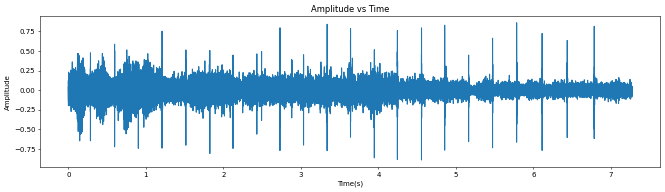

In [10]:
file_no_outdoor=652 # sample outdoor file number
print('Outdoor:')
x_out, _ = load_audio(file_no_outdoor, display_audio=True)
visualise_audio(x_out, fs, visuals=['amp'])

Indoor:
/content/drive/MyDrive/Data/MLEndLS/MLEndLS/0561.wav : audio signal has 173534 samples


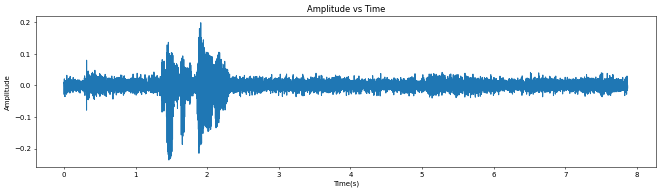

In [11]:
file_no_indoor=561 # sample indoor file number
print('Indoor:')
x_in, fs = load_audio(file_no_indoor, display_audio=True)
visualise_audio(x_in, fs, visuals=['amp'])

Outdoor:


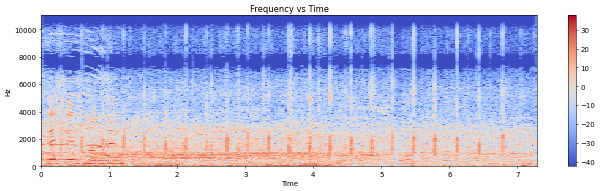

Indoor:


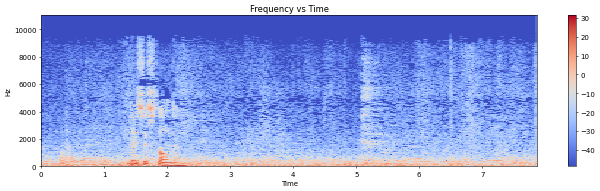

In [12]:
# comparing frequency spectograms
print('Outdoor:')
visualise_audio(x_out, fs, visuals=['freq'])
print('Indoor:')
visualise_audio(x_in, fs, visuals=['freq'])

Outdoor:


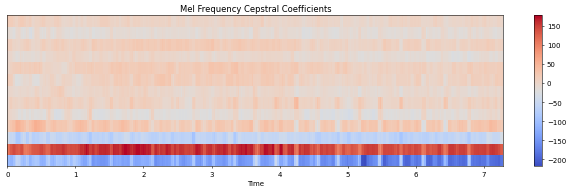

Indoor:


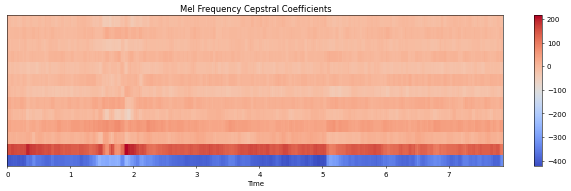

In [13]:
# comparing MFCC
print('Outdoor:')
visualise_audio(x_out, fs, visuals=['mfcc'])
print('Indoor:')
visualise_audio(x_in, fs, visuals=['mfcc'])

Outdoor:


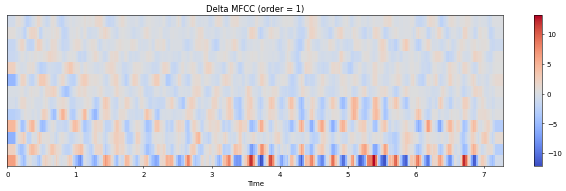

Indoor:


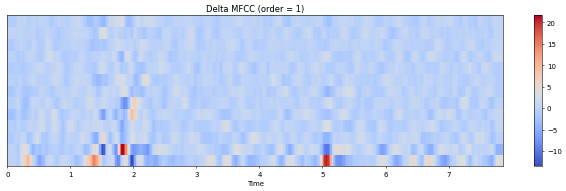

In [14]:
# comparing delta MFCC
print('Outdoor:')
visualise_audio(x_out, fs, visuals=['d_mfcc'])
print('Indoor:')
visualise_audio(x_in, fs, visuals=['d_mfcc'])

Outdoor:


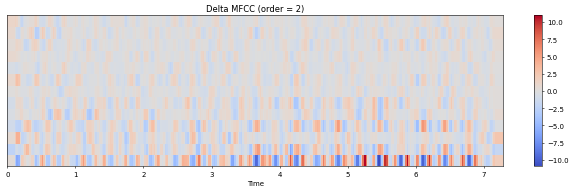

Indoor:


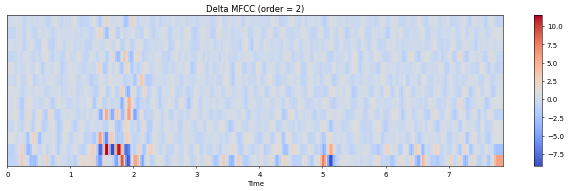

In [15]:
# comparing delta 2 MFCC
print('Outdoor:')
visualise_audio(x_out, fs, visuals=['d2_mfcc'])
print('Indoor:')
visualise_audio(x_in, fs, visuals=['d2_mfcc'])

Outdoor:


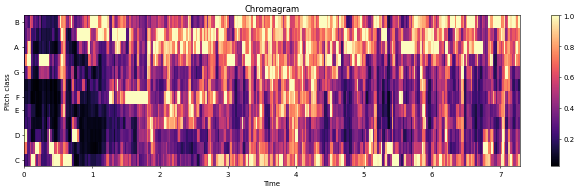

Indoor:


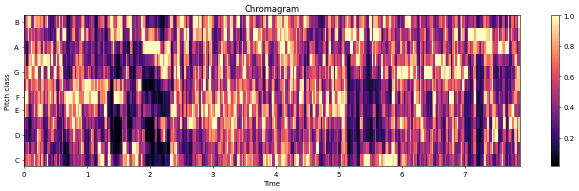

In [16]:
# comparing chromagrams
print('Outdoor:')
visualise_audio(x_out, fs, visuals=['chroma'])
print('Indoor:')
visualise_audio(x_in, fs, visuals=['chroma'])

Outdoor:


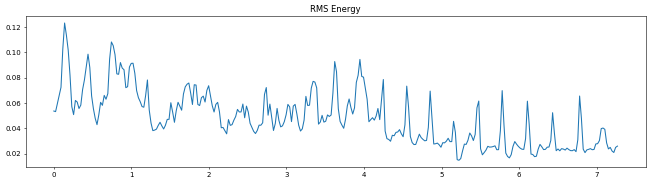

Indoor:


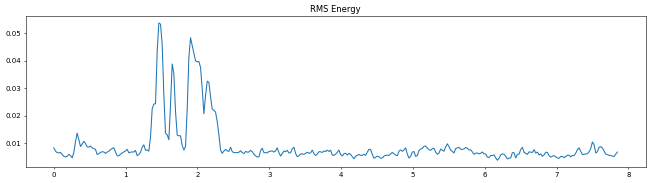

In [17]:
# comparing RMS energy
print('Outdoor:')
visualise_audio(x_out, fs, visuals=['energy'])
print('Indoor:')
visualise_audio(x_in, fs, visuals=['energy'])

Outdoor:


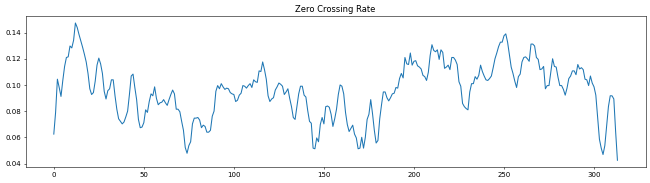

Indoor:


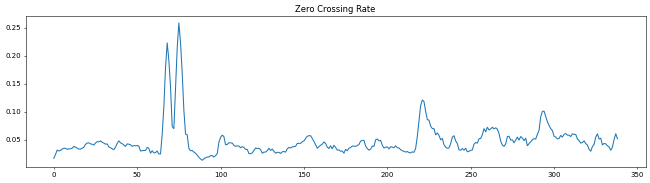

In [18]:
# comparing zero crossing rate
print('Outdoor:')
visualise_audio(x_out, fs, visuals=['zcr'])
print('Indoor:')
visualise_audio(x_in, fs, visuals=['zcr'])

Outdoor:


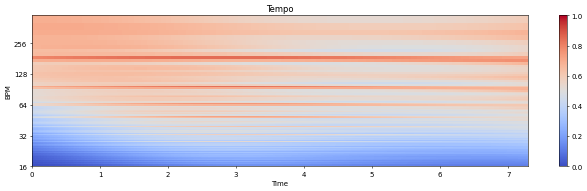

Indoor:


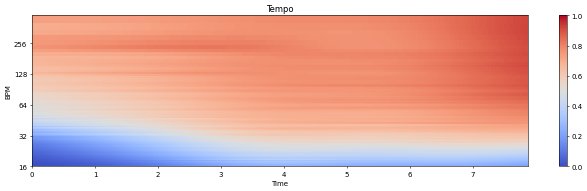

In [19]:
# comparing frequency spectograms
print('Outdoor:')
visualise_audio(x_out, fs, visuals=['tempo'])
print('Indoor:')
visualise_audio(x_in, fs, visuals=['tempo'])

In [34]:
pp_audio_class = X_train[['voiced_fr', 'intro_power', 'intro_pitch_mean', 
                           'power', 'tempo', 'zcr_mean', 'chroma_mean_1', 
                           'mfcc_mean_1', 'd_mfcc_mean_1', 'd2_mfcc_mean_1' ]]
pp_audio_class['in_out'] = y_train
pp_audio_class.head()

<ipython-input-34-b39cd860d573>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_audio_class['in_out'] = y_train


voiced_fr  intro_power  intro_pitch_mean     power       tempo  \
file_id                                                                    
0652.wav   0.038217     0.344559          0.000000  0.005620   99.384014   
0561.wav   0.079646     0.015863        117.821647  0.000356  129.199219   
0920.wav   0.143312     0.001358          0.000000  0.000573  123.046875   
2264.wav   0.069672     0.133132        262.333052  0.000159  117.453835   
1589.wav   0.089888     0.028679        126.439323  0.000502  135.999178   

          zcr_mean  chroma_mean_1  mfcc_mean_1  d_mfcc_mean_1  d2_mfcc_mean_1  \
file_id                                                                         
0652.wav  0.094731       0.604962   -143.51695      -0.272538        0.020651   
0561.wav  0.048269       0.565397   -362.80515      -0.380050        0.066378   
0920.wav  0.051789       0.488571   -379.92370       0.015571       -0.072295   
2264.wav  0.084803       0.465072   -326.48190      -0.187210        0.065440   
1589.wav  0.084414       0.584465   -274.20870      -0.027208        0.032840   

           in_out  
file_id            
0652.wav  outdoor  
0561.wav   indoor  
0920.wav  outdoor  
2264.wav  outdoor  
1589.wav  outdoor

In [ ]:
# Scatter plot of features 
sns.set_style("whitegrid");
sns.pairplot(pp_audio_class, hue='in_out', diag_kind="hist");
plt.show()

## 7.5 Feature Selection

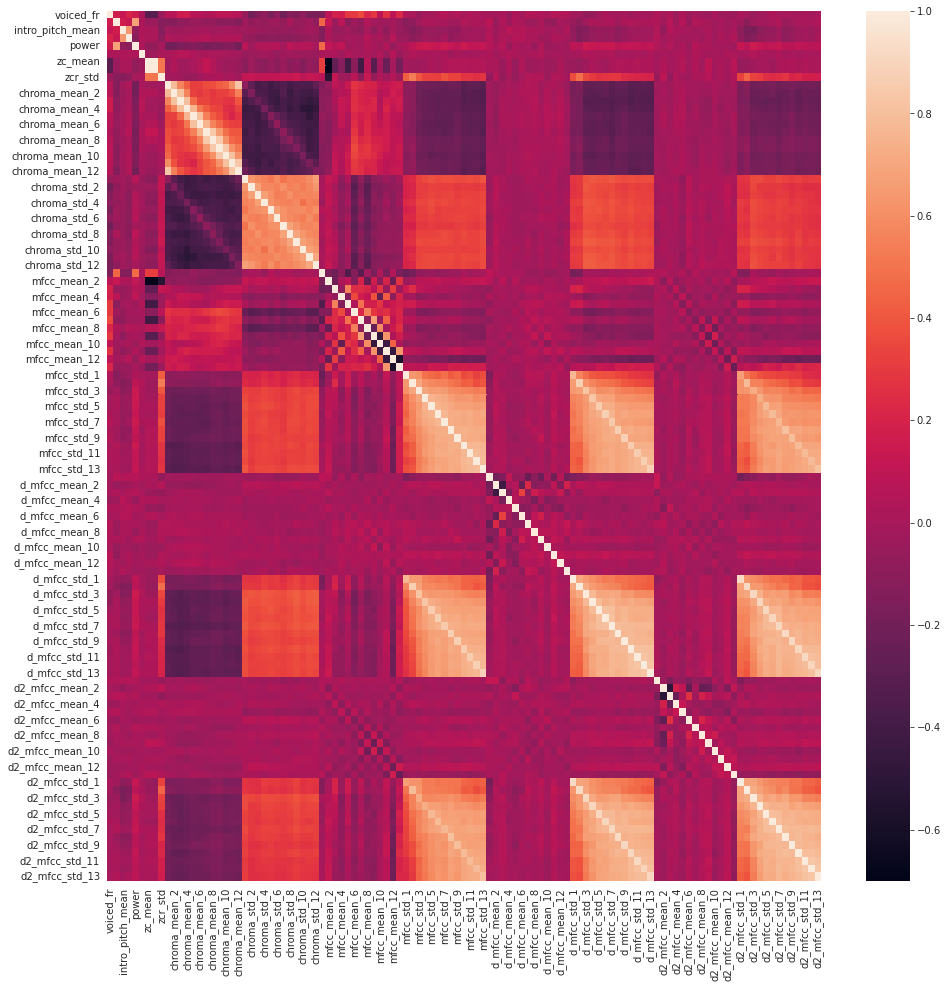

In [ ]:
# Correlation heatmap of features
X_corr = X_train.corr()
plt.figure(figsize=(16,16))
sns.heatmap(X_corr)
plt.show()

In [ ]:
# Identifying closely related features
corr_features = [] # using set so that there are no duplicates

for i in range(len(X_corr.columns)):
    for j in range(i):
        if (abs(X_corr.iloc[i, j]) >= 0.80): 
            colname = X_corr.columns[i]
            print(X_corr.columns[i], X_corr.columns[j], X_corr.iloc[i, j] )
            if colname not in corr_features:
              corr_features.append(colname) 

print(corr_features)
print(len(corr_features))

zcr_mean zc_mean 0.9999945248312926
chroma_mean_3 chroma_mean_2 0.8082862095487587
chroma_mean_4 chroma_mean_3 0.8013384831409198
chroma_mean_6 chroma_mean_5 0.8084333546715502
chroma_mean_8 chroma_mean_7 0.844476600899911
chroma_mean_9 chroma_mean_8 0.8484599918864042
chroma_mean_10 chroma_mean_9 0.8448694058967938
chroma_mean_11 chroma_mean_10 0.8126190699630129
chroma_mean_12 chroma_mean_1 0.8295278688537261
chroma_mean_12 chroma_mean_11 0.8366594241458148
d_mfcc_std_2 mfcc_std_2 0.8708133475909381
d_mfcc_std_3 mfcc_std_3 0.8239887909417453
d_mfcc_std_4 mfcc_std_4 0.8298224312989524
d_mfcc_std_5 mfcc_std_5 0.8564460984893507
d_mfcc_std_6 mfcc_std_6 0.8719933035631515
d_mfcc_std_6 d_mfcc_std_5 0.8054672813380779
d_mfcc_std_7 mfcc_std_7 0.847416664423436
d_mfcc_std_7 d_mfcc_std_6 0.8116636186276943
d_mfcc_std_8 mfcc_std_8 0.8692704956455877
d_mfcc_std_9 mfcc_std_9 0.87187736221617
d_mfcc_std_10 mfcc_std_10 0.8548746831936012
d_mfcc_std_11 mfcc_std_11 0.860893051971973
d_mfcc_std_11 d_

Observations -
*  The two features with highest correlation are - `zcr_mean` and `zc_mean`
*  The `d_mfcc_std_*` and `d2_mfcc_std_*` values have high correlation with the `mfcc_std_*` and `d_mfcc_std_*` respectively
*  The `chroma_mean_*` values have a high correlation with each other, however the `chroma_std_*` is not listed and can be assumed to not have high correlation (> 0.8). Both the mean and the standard deviation are calculated to represent the chroma feature. Thus, we will be keeping the `chroma_mean_[1-12]`

The following features will be dropped due to high correlation - `zc_mean`, `d_mfcc_std_[2-13]` and `d2_mfcc_std_[2-13]` features. We are keeping `d_mfcc_std_1` and `d2_mfcc_std_1` to avoid overfitting to training set. 

In [ ]:
corr_features_list = ['zcr_mean', 'd_mfcc_std_2', 
                      'd_mfcc_std_3', 'd_mfcc_std_4', 'd_mfcc_std_5', 
                      'd_mfcc_std_6', 'd_mfcc_std_7', 'd_mfcc_std_8', 
                      'd_mfcc_std_9', 'd_mfcc_std_10', 'd_mfcc_std_11', 
                      'd_mfcc_std_12', 'd_mfcc_std_13',  
                      'd2_mfcc_std_2', 'd2_mfcc_std_3', 'd2_mfcc_std_4', 
                      'd2_mfcc_std_5', 'd2_mfcc_std_6', 'd2_mfcc_std_7',
                      'd2_mfcc_std_8', 'd2_mfcc_std_9', 'd2_mfcc_std_10',
                      'd2_mfcc_std_11', 'd2_mfcc_std_12', 'd2_mfcc_std_13']

In [ ]:
X_train.drop(labels=corr_features_list, axis=1, inplace=True)
print('Number of columns in train dataset:', len(X_train.columns))
X_test.drop(labels=corr_features_list, axis=1, inplace=True)
print('Number of columns in test dataset:', len(X_test.columns))

Number of columns in train dataset: 86
Number of columns in test dataset: 86


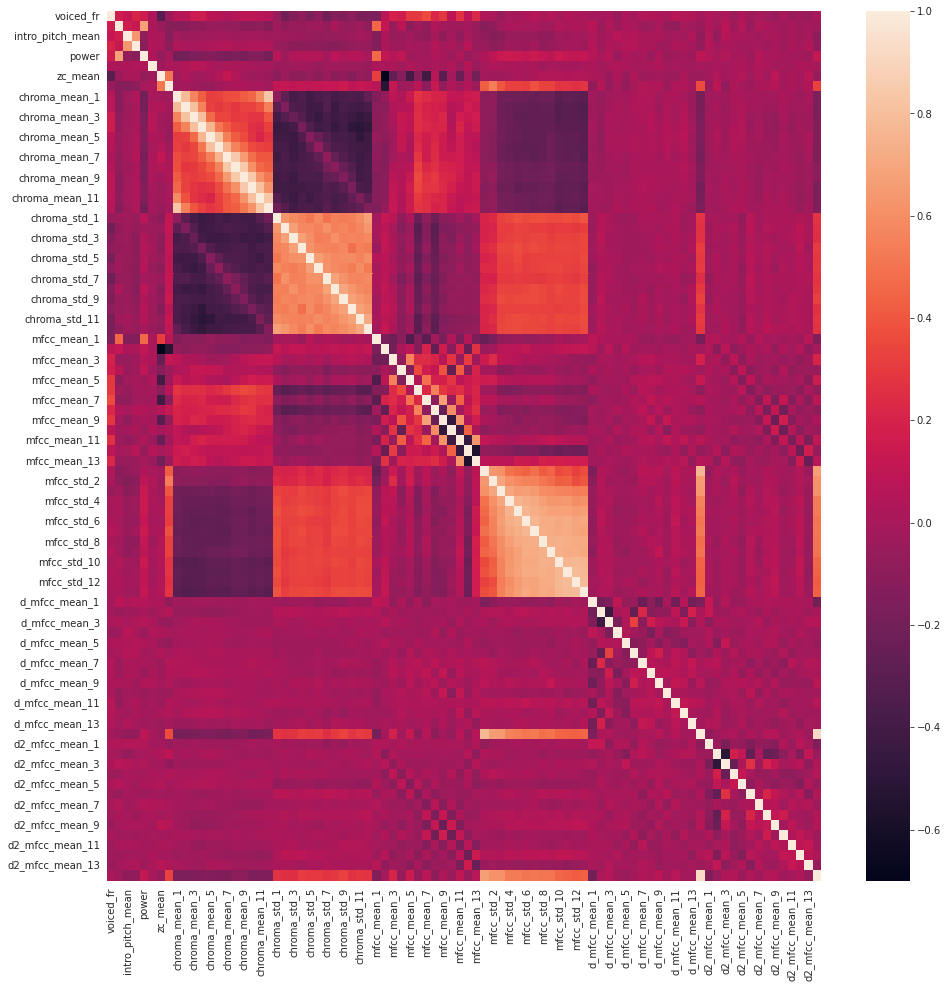

In [ ]:
# New Correlation heatmap of features after dropping columns
X_corr = X_train.corr()
plt.figure(figsize=(16,16))
sns.heatmap(X_corr)
plt.show()

# 8 Results



## 8.1 Model Selection

In [ ]:
family_models

[LogisticRegression(),
 GaussianNB(),
 LinearSVC(),
 KNeighborsClassifier(),
 DecisionTreeClassifier()]

In [ ]:
cvFamilyOfModels(X_train, y_train, family_models, k=5, eval_metric='accuracy')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'LogisticRegression': [0.7621478696741855, 0.02382326519440263],
 'GaussianNB': [0.7230964912280701, 0.015989825857052834],
 'LinearSVC': [0.6053822055137845, 0.037429205289911886],
 'KNeighborsClassifier': [0.6459624060150376, 0.022707132618896706],
 'DecisionTreeClassifier': [0.6825413533834587, 0.02874237176231329]}

A few models fail to converge, we can try to standardise the values to mitigate this issue.

In [ ]:
cvFamilyOfModels(X_train, y_train, family_models, k=5, eval_metric='accuracy', scaler=True)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'LogisticRegression': [0.7982017543859647, 0.016453068113735238],
 'GaussianNB': [0.7195864661654136, 0.01595211221071183],
 'LinearSVC': [0.8037130325814538, 0.019101006667863893],
 'KNeighborsClassifier': [0.7356228070175439, 0.017942751132463457],
 'DecisionTreeClassifier': [0.6875413533834587, 0.020431778649546206]}

Logistic Regression and Linear SVM models hav out performed all other models. However, the Linear SVM still faces convergence issues. Thus, we will select these two models for hyperparameter tuning and further analysis.

## 8.2 Hyperparameter Tuning

### Logistic Regression Classifier

In [ ]:
log_reg_params = {'solver':['liblinear'], 
              'C':[ 0.01, 0.1, 1, 10, 100], 
              'penalty': ['l1', 'l2'],
              'class_weight': [None, 'balanced'],
              'random_state': [1]}

In [ ]:
log_reg_results = tuningModel(X_train, y_train, LogisticRegression(), log_reg_params, scaler=True)
display(log_reg_results)

mean_fit_time                                             params  \
0        0.019497  {'C': 0.01, 'class_weight': None, 'penalty': '...   
1        0.053621  {'C': 0.01, 'class_weight': None, 'penalty': '...   
2        0.028518  {'C': 0.01, 'class_weight': 'balanced', 'penal...   
3        0.046564  {'C': 0.01, 'class_weight': 'balanced', 'penal...   
4        0.085045  {'C': 0.1, 'class_weight': None, 'penalty': 'l...   
5        0.091708  {'C': 0.1, 'class_weight': None, 'penalty': 'l...   
6        0.096971  {'C': 0.1, 'class_weight': 'balanced', 'penalt...   
7        0.070932  {'C': 0.1, 'class_weight': 'balanced', 'penalt...   
8        0.124910  {'C': 1, 'class_weight': None, 'penalty': 'l1'...   
9        0.113615  {'C': 1, 'class_weight': None, 'penalty': 'l2'...   
10       0.120493  {'C': 1, 'class_weight': 'balanced', 'penalty'...   
11       0.105972  {'C': 1, 'class_weight': 'balanced', 'penalty'...   
12       0.237619  {'C': 10, 'class_weight': None, 'penalty': 'l1...   
13       0.187111  {'C': 10, 'class_weight': None, 'penalty': 'l2...   
14       0.159953  {'C': 10, 'class_weight': 'balanced', 'penalty...   
15       0.125644  {'C': 10, 'class_weight': 'balanced', 'penalty...   
16       0.213751  {'C': 100, 'class_weight': None, 'penalty': 'l...   
17       0.125517  {'C': 100, 'class_weight': None, 'penalty': 'l...   
18       0.179599  {'C': 100, 'class_weight': 'balanced', 'penalt...   
19       0.078169  {'C': 100, 'class_weight': 'balanced', 'penalt...   

    mean_test_score  std_test_score  rank_test_score  
0          0.736608        0.007033               20  
1          0.787203        0.020037                8  
2          0.738608        0.006636               19  
3          0.783194        0.017211               16  
4          0.798213        0.015101                1  
5          0.784187        0.011912               13  
6          0.795207        0.017352                2  
7          0.783693        0.014641               15  
8          0.787189        0.012428               10  
9          0.787689        0.010273                7  
10         0.787192        0.009380                9  
11         0.785188        0.008902               11  
12         0.788189        0.009422                5  
13         0.788690        0.009802                3  
14         0.784687        0.010660               12  
15         0.784185        0.009863               14  
16         0.788189        0.009422                5  
17         0.788689        0.008751                4  
18         0.783185        0.010939               17  
19         0.783185        0.010939               17

### Linear Support Vector Machine Classifier

In [ ]:
lin_svc_params = {'penalty': ['l1', 'l2'],
                  'C':[ 0.01, 0.1], 
                  'loss': ['hinge', 'squared_hinge'],
                  'class_weight': [None, 'balanced'],
                  'random_state': [1]}

In [ ]:
lin_svc_results = tuningModel(X_train, y_train, LinearSVC(), lin_svc_params, scaler=True)
display(lin_svc_results)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

mean_fit_time                                             params  \
0        0.005694  {'C': 0.01, 'class_weight': None, 'loss': 'hin...   
1        0.024069  {'C': 0.01, 'class_weight': None, 'loss': 'hin...   
2        0.006030  {'C': 0.01, 'class_weight': None, 'loss': 'squ...   
3        0.057527  {'C': 0.01, 'class_weight': None, 'loss': 'squ...   
4        0.008505  {'C': 0.01, 'class_weight': 'balanced', 'loss'...   
5        0.023293  {'C': 0.01, 'class_weight': 'balanced', 'loss'...   
6        0.006247  {'C': 0.01, 'class_weight': 'balanced', 'loss'...   
7        0.059586  {'C': 0.01, 'class_weight': 'balanced', 'loss'...   
8        0.006158  {'C': 0.1, 'class_weight': None, 'loss': 'hing...   
9        0.063964  {'C': 0.1, 'class_weight': None, 'loss': 'hing...   
10       0.005778  {'C': 0.1, 'class_weight': None, 'loss': 'squa...   
11       0.396698  {'C': 0.1, 'class_weight': None, 'loss': 'squa...   
12       0.006166  {'C': 0.1, 'class_weight': 'balanced', 'loss':...   
13       0.062238  {'C': 0.1, 'class_weight': 'balanced', 'loss':...   
14       0.007401  {'C': 0.1, 'class_weight': 'balanced', 'loss':...   
15       0.379986  {'C': 0.1, 'class_weight': 'balanced', 'loss':...   

    mean_test_score  std_test_score  rank_test_score  
0               NaN             NaN                9  
1          0.785694        0.014500                4  
2               NaN             NaN               10  
3          0.784189        0.014264                7  
4               NaN             NaN               11  
5          0.785193        0.013960                6  
6               NaN             NaN               12  
7          0.783690        0.013799                8  
8               NaN             NaN               13  
9          0.786192        0.011575                3  
10              NaN             NaN               14  
11         0.786688        0.011313                1  
12              NaN             NaN               15  
13         0.786198        0.018148                2  
14              NaN             NaN               16  
15         0.785692        0.012497                5

In [ ]:
log_reg_results.iloc[4]

mean_fit_time                                               0.085045
params             {'C': 0.1, 'class_weight': None, 'penalty': 'l...
mean_test_score                                             0.798213
std_test_score                                              0.015101
rank_test_score                                                    1
Name: 4, dtype: object

In [ ]:
lin_svc_results.iloc[11]

mean_fit_time                                               0.396698
params             {'C': 0.1, 'class_weight': None, 'loss': 'squa...
mean_test_score                                             0.786688
std_test_score                                              0.011313
rank_test_score                                                    1
Name: 11, dtype: object

Comparing the best result of Logistic and Linear SVC, we can say that Logistic is the fastest. Assuming that accuracies are normally distributed (that mean +/- 3 * std) across the folds, Logistic Regression performance lies between [75.3, 84.3] and Linear SVM lies between [75.4, 82].

Analysing the metrics, we will select **Logistic Regression Classifier** as our final model to train.

In [ ]:
log_reg_results.iloc[4]['params']

{'C': 0.1,
 'class_weight': None,
 'penalty': 'l1',
 'random_state': 1,
 'solver': 'liblinear'}

## 8.3 Training

In [ ]:
final_model = LogisticRegression(C = 0.1, 
                                 class_weight = None,
                                 penalty = 'l1',
                                 random_state = 1,
                                 solver = 'liblinear')

final_model_pipeline = Pipeline([('scaler', StandardScaler()), ('model_training', final_model)])

final_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model_training',
                 LogisticRegression(C=0.1, penalty='l1', random_state=1,
                                    solver='liblinear'))])

## 8.4 Testing

In [ ]:
y_test_pred = final_model_pipeline.predict(X_test)

In [ ]:
classification_report(y_test, y_test_pred, output_dict=True)

{'indoor': {'precision': 0.7943548387096774,
  'recall': 0.8140495867768595,
  'f1-score': 0.8040816326530611,
  'support': 242},
 'outdoor': {'precision': 0.8214285714285714,
  'recall': 0.8023255813953488,
  'f1-score': 0.8117647058823529,
  'support': 258},
 'accuracy': 0.808,
 'macro avg': {'precision': 0.8078917050691243,
  'recall': 0.8081875840861041,
  'f1-score': 0.807923169267707,
  'support': 500},
 'weighted avg': {'precision': 0.8083248847926267,
  'recall': 0.808,
  'f1-score': 0.8080460984393757,
  'support': 500}}

Observations:

*  Accuracy of the model on the test dataset is 80.8%. 
*  The weighted avergae F1-score score shows that the performance of the model in balancing classifications for both indoor and outdoor is high, that is the model is not verfitted to one class. 
*  The confusion matrix helps visualise the class predictions, where we observed that the false positives and false negatives are darker, indicatig that a small number of classes have been misclassified.

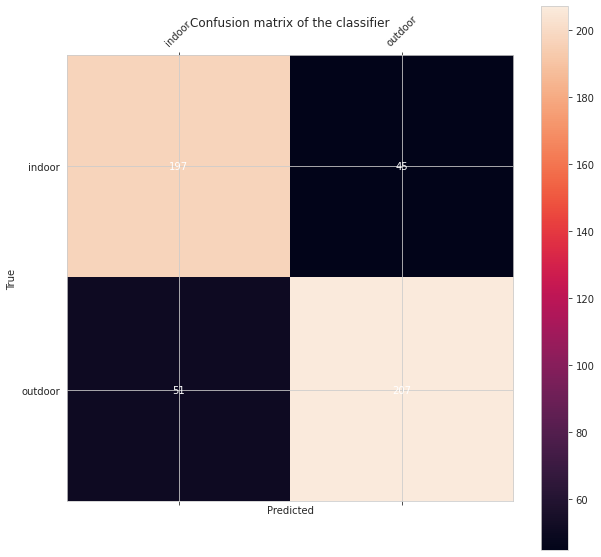

In [ ]:
labels=['indoor', 'outdoor']
cm = confusion_matrix(y_test, y_test_pred, labels=labels)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels( labels, rotation=45)
ax.set_yticklabels( labels)

for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                        ha="center", va="center", color="w")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 9 Conclusions

The accuracy on the test dataset lies within the estimated accuracy range - [75.3, 84.3]. Thus, we can conclude that our model is performing as expected.